# Weather station wind data (LT and NRT)
Fernando Abárzuza | <fernando.abarzuza@gmail.com> | 3rd May 2024

This notebook explores the wind data from LT and NRT weather stations in order to identify significant differences between both datasets. For now, only data from the last 3 months (Feb 7th - now) has been analysed.

In [3]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pycircular
from aspred.connector import lt_data


In [4]:
# Import LT weather data
df1 = lt_data()

## Wind speed distribution

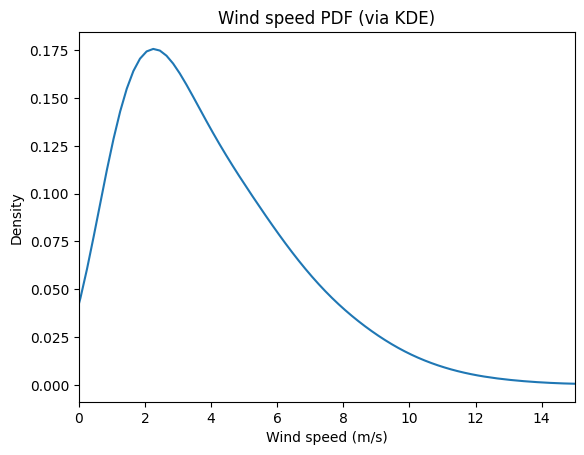

In [5]:
df1["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
plt.xlabel(xlabel="Wind speed (m/s)")
plt.show()

## Wind direction distribution

A polar scatter plot can help us visualise the most frequent wind speed and directions.

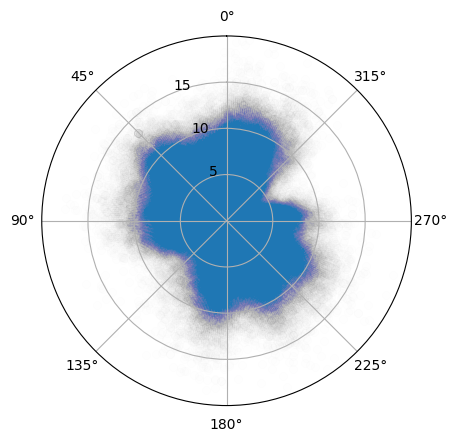

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(df1["wind_direction_radians"], df1["wind_speed"], alpha=0.005)
ax.set_rmax(20)
ax.set_rticks([5, 10, 15])
ax.set_theta_zero_location('N')

To get an idea of the density of the data, we can use a density estimator to approximate a continuous PDF, this is, a function $p$ such that $$\int_0^{2\pi} p(\theta) d\theta = 1$$ and $$\int_{\theta_1}^{\theta_2} p(\theta) d\theta$$ gives the probability of the wind direction being in the interval $[\theta_1, \theta_2]$.

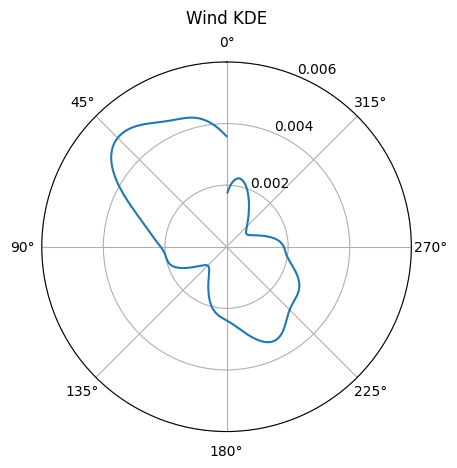

In [7]:
kde = scipy.stats.gaussian_kde(df1["wind_direction"])
theta = np.arange(0, 360, 1)
r = kde(theta)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta/360*2*np.pi, r)
ax.set_rmax(0.006)
ax.set_rticks([0.002, 0.004, 0.006])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
plt.show()

Linear KDE is not applicable because our data is angular and, therefore, modular (see the discontinuity of the KDE at $\theta = 0\;\text{deg}$). There aren't many tools designed to do KDE analysis on circular data. We try the `pycircular` package.

We first select a sample to calculate the bandwith.

In [8]:
wind_sample = df1["wind_direction_radians"].sample(n=2000).tolist()
wind_sample
bw = pycircular.circular.bwEstimation(wind_sample)
print("Suggested bandwidth:",bw)

Suggested bandwidth: 59.332703323936556


In [9]:
circular_kde = pycircular.circular.kernel(df1["wind_direction_radians"], bw=bw, n=256)

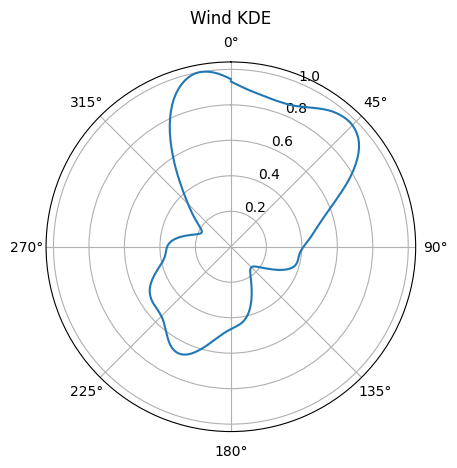

In [10]:
x = np.linspace(0, 2*np.pi, 256)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
ax.set_theta_direction(-1)
ax.plot(x, circular_kde)
plt.show()

https://gist.github.com/jobovy/a10a97353b8200b397de1f35a6525ece

# NRT Weather data

**Connector doesn't work**. In contact with Joao to get the right credentials.

In [9]:
from influxdb import InfluxDBClient

host = 'influxdb.services.newrobotictelescope.org'
port = 8086
username = 'nrt-admin'
password = 'super_secret_password'
ssl = True
verify_ssl = True

client = InfluxDBClient(host=host, port=port, username=username, password=password, ssl=ssl, verify_ssl=verify_ssl)
client.get_list_database()

ModuleNotFoundError: No module named 'influxdb'

Temporary solution: download the data and load it locally.

In [15]:
from aspred.utils import standard_angle

data_path = "../data/2024-05-03_13_51_influxdb_data.csv"
col_names = ["start_date", "end_date", "date", "value", "field", "measurement", "device", "site", "source", "subsystem"]


with open(data_path) as file:
    filedata = file.read()

# Ignore the first columns of data    
filedata = filedata.replace(",,0,", "")
filedata = filedata.replace(",,1,", "")


# Save data again
with open(data_path, "w") as file:
    file.write(filedata)
    
# Import file in pandas
df2 = pd.read_csv(data_path, sep=",", names = col_names, skiprows=4)

# Drop rows in which the date is longer than 20 characters
# For some reason Infux outputs the last measurement with more precision than the other measurements
df2 = df2[df2["date"].str.len() <= 20]

# Extract wind speed and direction in different dataframes and convert date to datetime
df2_direction = df2[df2["field"] == "wind_direction_avg"]
df2_direction = df2_direction[["date", "value"]]
df2_direction["date"] = pd.to_datetime(df2_direction["date"], format="%Y-%m-%dT%H:%M:%SZ")

df2_speed = df2[df2["field"] == "wind_speed_avg"]
df2_speed = df2_speed[["date", "value"]]
df2_speed["date"] = pd.to_datetime(df2_speed["date"], format="%Y-%m-%dT%H:%M:%SZ")

# Merge both dataframes on date
df2 = pd.merge(df2_speed, df2_direction, on="date", suffixes=("_speed", "_direction"))

# Change the name of the columns to make it consistent with the LT data
df2 = df2.rename(columns={"date": "date", "value_speed": "wind_speed", "value_direction": "wind_direction"})

# Convert wind direction to radians
df2["wind_direction_radians"] = df2["wind_direction"].apply(lambda x: standard_angle(np.radians(x)))

We can now perform the same plots as with the LT weather data. First, however, from the LT data, we need to select the same time period as the NRT data, starting from February 7th 2024. For some reason, there is a gap in the LT weather data, starting at 02-19. We will start the analysis from 02-20.

In [16]:
# df1_restricted = df1[df1["date"] >= "2024-01-01"]

df1_restricted = df1[df1["date"] >= "2023-02-19"]
df2_restricted = df2[df2["date"] >= "2023-02-19"]

## Wind speed distribution comparison

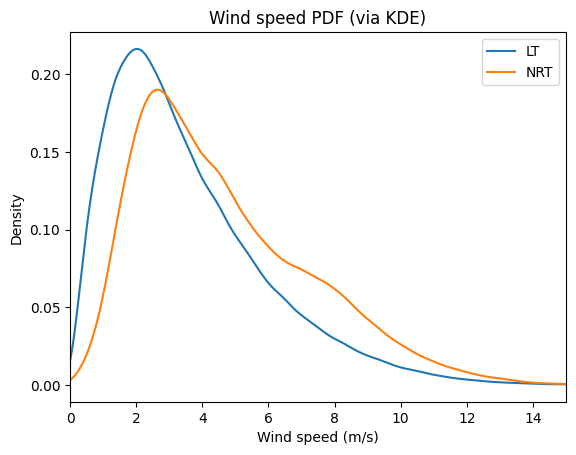

In [17]:
df1_restricted["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
df2_restricted["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
plt.xlabel(xlabel="Wind speed (m/s)")
plt.legend(["LT", "NRT"])

## Wind direction distribution comparison

In [18]:
wind_sample = df2_restricted["wind_direction_radians"].sample(n=2000).tolist()
# bw = pycircular.circular.bwEstimation(wind_sample)
print("Suggested bandwidth:",bw)

Suggested bandwidth: 59.332703323936556


In [19]:
circular_kde1 = pycircular.circular.kernel(df1_restricted["wind_direction_radians"].tolist(), bw=bw, n=256)
circular_kde2 = pycircular.circular.kernel(df2_restricted["wind_direction_radians"].tolist(), bw=bw, n=256)

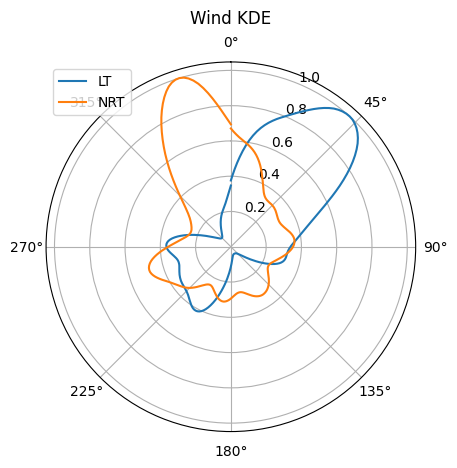

In [24]:
x = np.linspace(0, 2*np.pi, 256)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
ax.set_theta_direction(-1)
ax.plot(x, circular_kde1, label="LT")
ax.plot(x, circular_kde2, label="NRT")
plt.legend()
plt.show()

Possible explanations:
* An actual difference in the wind distribution between both locations due, probably, to the topography and interference of terrain/buildings etc.
* An error in the data collection process. We should look into the calibration of both weather stations and maybe compare to a third one.

## Questions and next steps
* It appears that there are significant differnces in the wind distribution, particularly in the direction. LT has a predominantly N-W wind, at 340 degrees. NRT has a predominantly northern wind, with the most likely direction at 40 degrees.
* Wind speed is more similar. LT data shows more frequent windspeeds under 2 m/s. NRT data has a higher frequency of winds in the 2-5 m/s range. However, after 5m/s, the wind distribution is very similar.
* This data is, however, restricted to the last 3 months. It would be interesting to see if these differences are consistent throughout the year. Legacy weather data from NRT has to be analysed.
* It would also be interesting to evaluate the peak in wind speeds (wind gusts), as they can dramatically affect the telescope operation. NRT weather station has a min/max record, but LT does not record this information.

Next steps:
1. Compute the difference in wind direction from both datasets and plot. Check if the bias is consistent throughout the period.
2. Try to explain this bias. Plot a topographic map around both locations and check the earth gradient.


# Smoothing data and finding trends
Data on wind directions shows a huge amount of variability. We can smooth the data to find trends. We can use a moving average or a Savitzky-Golay filter.

First, we will try a moving average.

In [18]:
# Define a time interval in minutes
interval = 30
window = pd.Timedelta(minutes=interval)

# Initial time (minus timedelta of 10 min to ensure completeness)
timedelta = pd.Timedelta(minutes=10)
initial_date = min(min(df1_restricted["date"]), min(df2_restricted["date"])) - timedelta
final_date = max(max(df1_restricted["date"]), max(df2_restricted["date"])) + timedelta

# Empty dataframe to store the smoothed data
df_smoothed = pd.DataFrame(columns=["date", "wind_direction_radians_LT", "wind_direction_radians_NRT"])

# Create empty lists to store the smoothed data
list_times = []
list_wind_direction_means1 = []
list_wind_direction_means2 = []
list_wind_speed_means1 = []
list_wind_speed_means2 = []

# Iterate over the time interval
time = initial_date
while time < final_date:
    # Create averages for each dataset
    time_to_append = time + window/2
    mask1 = (df1_restricted["date"] >= time) & (df1_restricted["date"] < time + window)
    mask2 = (df2_restricted["date"] >= time) & (df2_restricted["date"] < time + window)
    mean1 = scipy.stats.circmean(df1_restricted[mask1]["wind_direction_radians"])
    mean2 = scipy.stats.circmean(df2_restricted[mask2]["wind_direction_radians"])
    speed_mean1 = df1_restricted[mask1]["wind_speed"].mean()
    speed_mean2 = df2_restricted[mask2]["wind_speed"].mean()
    # Append to the lists
    list_times.append(time_to_append)
    list_wind_direction_means1.append(mean1)
    list_wind_direction_means2.append(mean2)
    list_wind_speed_means1.append(speed_mean1)
    list_wind_speed_means2.append(speed_mean2)
    time += window
    print("Processed", time, "of", final_date, end="\r")

# Assemble the dataframe
df_smoothed["date"] = list_times
df_smoothed["wind_direction_radians_LT"] = list_wind_direction_means1
df_smoothed["wind_direction_radians_NRT"] = list_wind_direction_means2
df_smoothed["wind_speed_LT"] = list_wind_speed_means1
df_smoothed["wind_speed_NRT"] = list_wind_speed_means2
df_smoothed["wind_direction_difference"] = (df_smoothed["wind_direction_radians_NRT"] - df_smoothed["wind_direction_radians_LT"]).apply(lambda x: standard_angle(x))
df_smoothed["wind_speed_difference"] = df_smoothed["wind_speed_NRT"] - df_smoothed["wind_speed_LT"]

NameError: name 'list_means1' is not defined

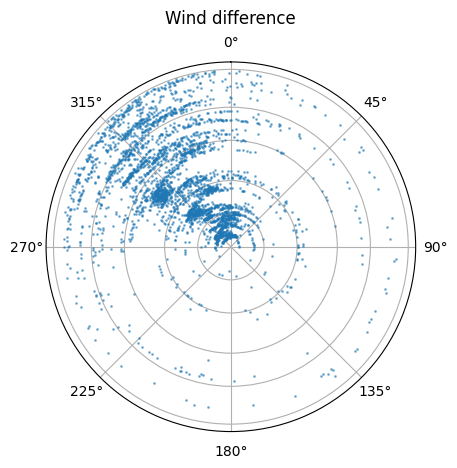

In [20]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind difference", va='bottom')
ax.set_theta_direction(-1)
# Hide the radial labels
ax.set_yticklabels([])
ax.plot(df_smoothed["wind_direction_difference"],df_smoothed["date"], linestyle="", marker="o", alpha=0.5, markersize=1)
plt.show()


The plot above shows the evolution of the wind differences between LT and NRT weather stations. The radial distance represents the time (center for older data, outer for newer data). There exists a clear bias in the wind direction difference. This bias is not fully random, as it seems to oscillate around a value close to $\theta=315\;\text{deg}$.

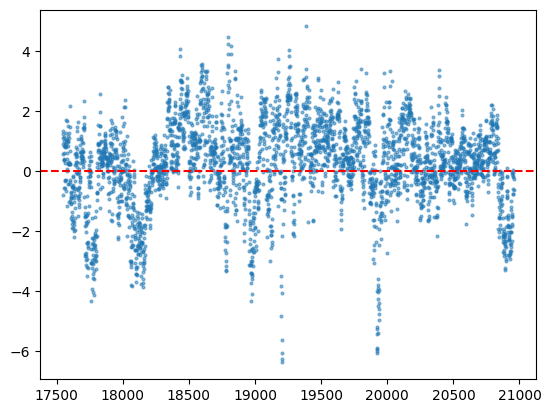

In [21]:
df_smoothed["wind_speed_difference"].plot(linestyle="", marker="o", alpha=0.5, markersize=2)
plt.axhline(y=0, color="red", linestyle="--")
plt.show()

The same analysis with the wind speed shows that the speed in NRT is consistently higher than in LT (again, only for data from the last 3 months).

# Old data from Carlsberg (CMT)

In [26]:
path = "../data/carlsberg.weather.data/janjun96.met"

df_cmt = pd.read_csv(path, sep='\s+', header=None, names=["year", "month", "day", "hour", "minute", "second", "pressure", "temperature", "wind_speed", "wind_direction", "humidity", "interior_temperature", "acceptance"])

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_49275/1896426427.py:3: SyntaxWarning: invalid escape sequence '\s'
  df_cmt = pd.read_csv(path, sep='\s+', header=None, names=["year", "month", "day", "hour", "minute", "second", "pressure", "temperature", "wind_speed", "wind_direction", "humidity", "interior_temperature", "acceptance"])


In [43]:
test = " 1996  1  1  0 20 20  775.1    10.9   5 233   7   20.2 00000"

In [44]:
test = test.split(" ")

In [45]:
test = [i for i in test if i]

In [46]:
test

['1996',
 '1',
 '1',
 '0',
 '20',
 '20',
 '775.1',
 '10.9',
 '5',
 '233',
 '7',
 '20.2',
 '00000']

In [49]:
from datetime import datetime


def decode_CMT_line(line: str)-> list:
    """ Decodes a line from the CMT weather data file and returns a list with the values
    
    :param line: str
        Line from the CMT weather data file
        
    :return: list
        List with the values
    """
    
    line = line.split(" ")
    line = [i for i in line if i]
    return line

def cmt_data(path: str = "../data/carlsberg.weather.data/janjun96.met")-> pd.DataFrame:
    """ Imports the CMT weather data and returns a pandas DataFrame
    
    :param path: str
        Path to the CMT weather data file
        
    :return: pd.DataFrame
        DataFrame with the CMT weather data
    """
    date_list = []
    pressure_list = []
    temperature_list = []
    wind_speed_list = []
    wind_direction_list = []
    humidity_list = []
    interior_temperature_list = []
    acceptance_list = []
    
    for line in open(path):
        line = decode_CMT_line(line)
        date = datetime(int(line[0]), int(line[1]), int(line[2]), int(line[3]), int(line[4]), int(line[5]))
        date_list.append(date)
        pressure_list.append(float(line[6]))
        temperature_list.append(float(line[7]))
        wind_speed_list.append(float(line[8]))
        wind_direction_list.append(float(line[9]))
        humidity_list.append(float(line[10]))
        interior_temperature_list.append(float(line[11]))
        acceptance_list.append(int(line[12]))
        
    df = pd.DataFrame()
    df["date"] = date_list
    df["pressure"] = pressure_list
    df["temperature"] = temperature_list
    df["wind_speed"] = wind_speed_list
    df["wind_direction"] = wind_direction_list
    df["humidity"] = humidity_list
    df["interior_temperature"] = interior_temperature_list
    df["acceptance"] = acceptance_list
                                 
    return df

In [50]:
df_cmt = cmt_data()

In [51]:
df_cmt

,date,pressure,temperature,wind_speed,wind_direction,humidity,interior_temperature,acceptance
0,1996-01-01 00:00:20,775.8,10.9,5.0,238.0,7.0,18.6,0
1,1996-01-01 00:05:20,775.1,10.9,4.0,231.0,7.0,14.0,0
2,1996-01-01 00:10:20,775.1,10.6,4.0,243.0,7.0,16.6,0
3,1996-01-01 00:15:20,775.7,10.9,5.0,233.0,7.0,18.6,0
4,1996-01-01 00:20:20,775.1,10.9,5.0,233.0,7.0,20.2,0
...,...,...,...,...,...,...,...,...
50984,1996-06-30 23:38:40,782.2,15.6,0.0,152.0,2.0,15.0,0
50985,1996-06-30 23:43:40,782.3,15.2,0.0,151.0,2.0,15.0,0
50986,1996-06-30 23:48:40,782.3,15.0,0.0,149.0,2.0,14.9,0
50987,1996-06-30 23:53:40,782.2,14.9,0.0,145.0,2.0,14.4,0


<Axes: ylabel='Frequency'>

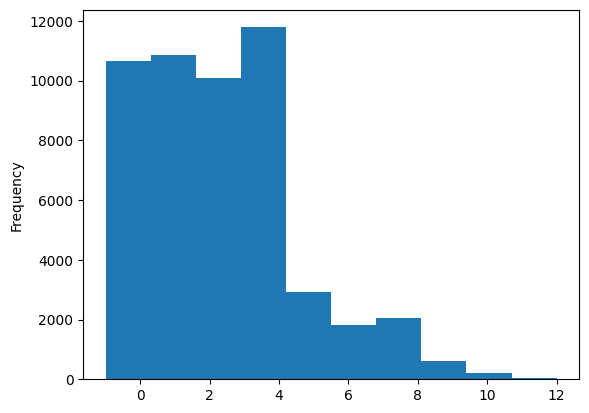

In [58]:
df_cmt["wind_speed"].plot.hist(bins=10)